In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [39]:
#constants
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.utils.image_dataset_from_directory(
    "PlantVillage",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
)


Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
68*32

2176

In [7]:
# First two batches
for image_batch, label_batch in dataset.take(2):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0]
(32, 256, 256, 3)
[1 0 1 0 0 1 0 1 0 1 1 1 1 0 1 2 1 0 0 2 0 1 1 1 1 2 1 0 0 0 0 0]


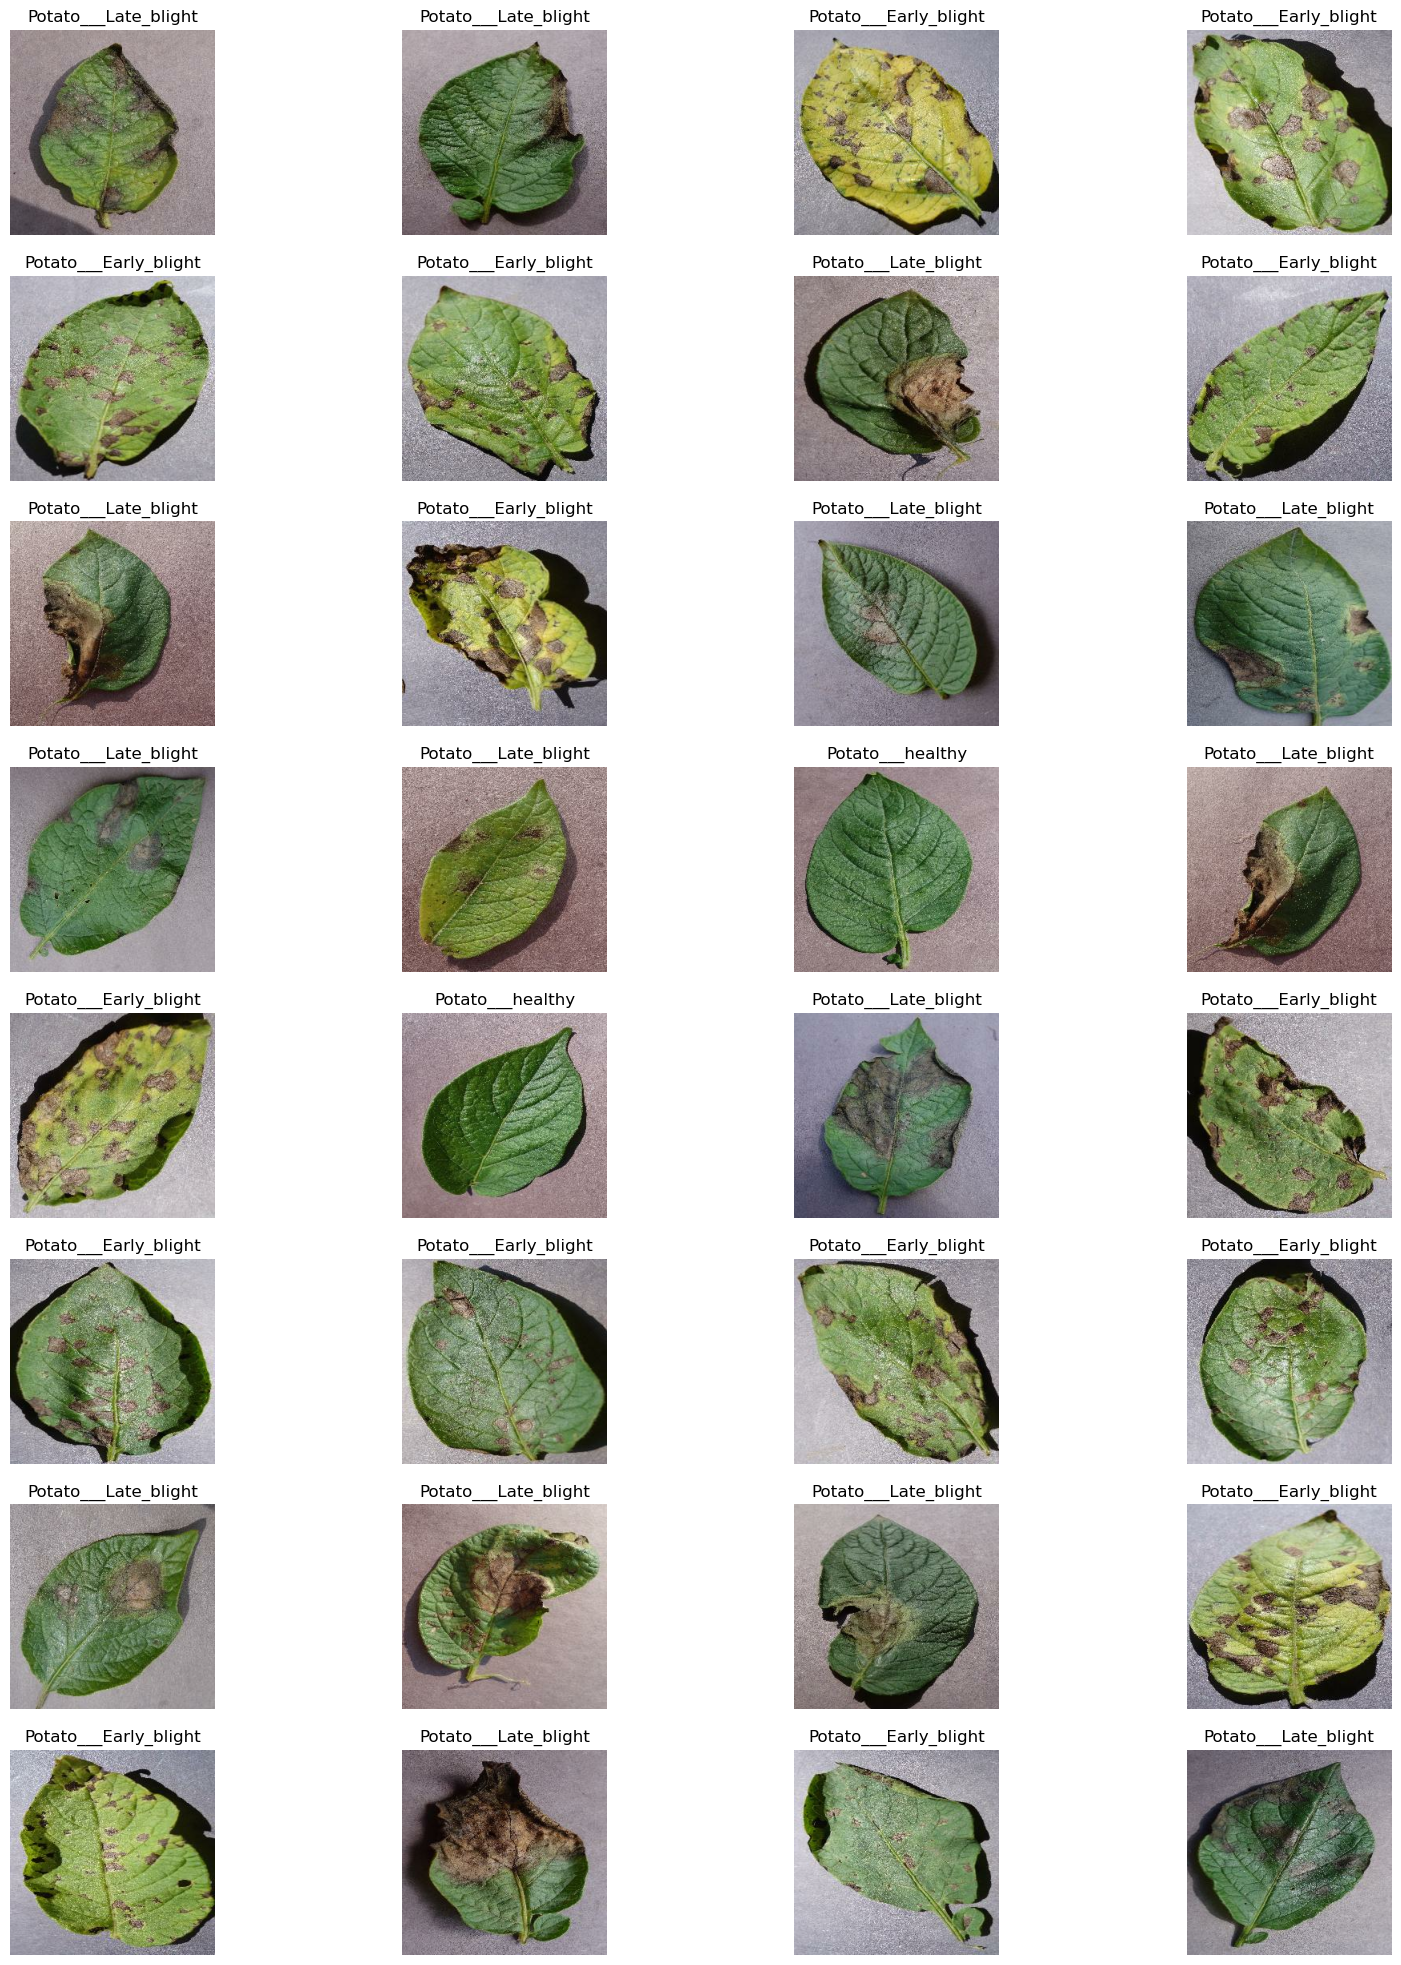

In [8]:
# First batch
plt.figure(figsize=(20, 25))  # Adjust the figure size as needed
plt.subplots_adjust(wspace=0.05)  # Adjust the wspace parameter
for image_batch, label_batch in dataset.take(1):
    for i in range(image_batch.shape[0]):
        ax=plt.subplot(image_batch.shape[0]//4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i].numpy()])
        plt.axis('off')
plt.show()

In [9]:
len(dataset)

68

In [10]:
'''
80% ==> Training
20% ==> 10% validation, 10% test
'''


'\n80% ==> Training\n20% ==> 10% validation, 10% test\n'

train_size=0.8
len(dataset)*train_size

train_ds = dataset.take(54)
len(train_ds)

test_ds = dataset.skip(54)
len(test_ds)

val_size=0.1
len(dataset)*val_size

val_ds = test_ds.take(6)
len(val_ds)

test_ds = test_ds.skip(6)
len(test_ds)

In [14]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:
        ds= ds.shuffle(shuffle_size,seed=42)
        
    train_size=int(train_split * ds_size)
    val_size=int(val_split * ds_size)
    test_ds=int(test_split * ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds= get_dataset_partition_tf(dataset)

In [17]:
print("Length of training set:",len(train_ds))
print("Length of validation set:",len(val_ds))
print("Length of test set:",len(test_ds))

Length of training set: 54
Length of validation set: 6
Length of test set: 8


In [19]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [26]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [33]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=input_shape)

In [35]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256, 3)             0         
                                                                 
 sequential_1 (Sequential)   (256, 256, 3)             0         
                                                                 
 conv2d_24 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [36]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [41]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 58s 1s/step - loss: 0.8830 - accuracy: 0.4994 - val_loss: 0.7651 - val_accuracy: 0.6198
Epoch 2/50
54/54 [==============================] - 50s 929ms/step - loss: 0.6864 - accuracy: 0.6884 - val_loss: 0.6793 - val_accuracy: 0.6771
Epoch 3/50
54/54 [==============================] - 50s 934ms/step - loss: 0.5451 - accuracy: 0.7588 - val_loss: 0.5356 - val_accuracy: 0.7656
Epoch 4/50
54/54 [==============================] - 54s 1s/step - loss: 0.3452 - accuracy: 0.8627 - val_loss: 0.1928 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 53s 985ms/step - loss: 0.2147 - accuracy: 0.9173 - val_loss: 0.2529 - val_accuracy: 0.8958
Epoch 6/50
54/54 [==============================] - 59s 1s/step - loss: 0.1370 - accuracy: 0.9548 - val_loss: 0.9039 - val_accuracy: 0.7552
Epoch 7/50
54/54 [==============================] - 52s 971ms/step - loss: 0.1512 - accuracy: 0.9513 - val_loss: 0.0997 - val_accuracy: 0.9583
Epoch 8/

In [43]:
score=model.evaluate(test_ds)

8/8 [==============================] - 2s 148ms/step - loss: 0.0445 - accuracy: 0.9844


In [44]:
history

In [45]:
score

[0.04450701177120209, 0.984375]

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [53]:
len(history.history['loss'])
print(history.history['loss'][0:5])

[0.8830011487007141, 0.6864425539970398, 0.5451309084892273, 0.34521952271461487, 0.21471157670021057]


In [54]:
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

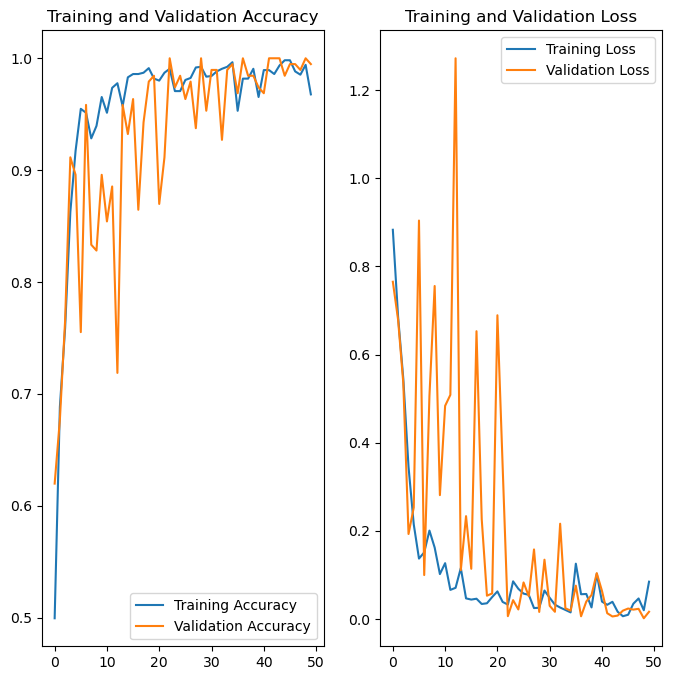

In [58]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
for image_batch, label_batch in test_ds.take(1);
    print